# 1 Instalation de Pyspark

In [371]:
#Install Pyspark
!pip install pyspark
!pip install findspark
!pip install koalas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2 Import des librairies

Avant toutes choses, nous installons différentes librairies :

* findspark --> permet d'initialiser Spark
* pyspark.sql --> est utilisé pour créer une session Spark et travailler avec des DataFrames 
* pyspark.sql.functions --> contient des fonctions utilitaires pour manipuler les données
* pyspark.sql.types --> permet de définir des types de données personnalisé
* matplotlib et "seaborn" --> utilisés pour créer des graphiques
* plotly --> utilisé pour créer des visualisations interactives
* numpy --> utilisé pour effectuer des calculs mathématiques
* pandas --> utilisé pour travailler avec des données en tant que DataFrames 
* wordcloud --> utilisé pour créer des nuages de mots


In [372]:
import findspark
findspark.init
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StringType,IntegerType,MapType,ArrayType,StructField
from pyspark.sql.functions import count,when,col,isnan,from_json,explode,map_keys,udf,coalesce,lit,to_date,year,split,get_json_object,array,collect_list,concat_ws,regexp_replace,regexp_extract
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib import cycler
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import os




# 3 Initialisation de la session

In [373]:
#Start Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

#4 Import des datasets

In [374]:
#Connection to my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [375]:
#Import datasets using the Databricks CSV library

ratings=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/ratings.csv")


movies_metadata=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/movies_metadata.csv")

keywords=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/keywords.csv")

credits=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/credits.csv")


links=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/links.csv")


ratings_sample=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/archive/ratings_small.csv")


# 5 Analyse Rapide

Schema, Description and Null values of datasets

In [376]:
dfs = [ratings,movies_metadata,keywords,credits,links,ratings_sample]

In [377]:
from pyspark.sql.functions import isnull, count

def dataframe_info(df_list):
    """
    Cette fonction prend en entrée une liste de dataframe et renvoie les informations suivantes pour chaque dataframe:
    - Schéma
    - Nombre de valeurs nulles
    - Description
    - Nombre de colonnes et de lignes pour chaque dataframe
    """
    for i, df in enumerate(df_list):
        print(f"Dataframe {i+1}")
        # Afficher le schéma
        print("Schema:")
        df.printSchema()
        print("\n")
        
        # Compter le nombre de valeurs nulles
        print("Nombre de valeurs nulles:")
        df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
        print("\n")
        
        # Afficher la description
        print("Description:")
        df.describe().show()
        print("\n")
        
        # Autres informations utiles
        print("Autres informations utiles:")
        print(f"Nombre de lignes: {df.count()}")
        print(f"Nombre de colonnes: {len(df.columns)}")
        print("\n")

In [378]:
dataframe_info(dfs)

Dataframe 1
Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Nombre de valeurs nulles:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



Description:
+-------+-----------------+------------------+------------------+--------------------+
|summary|           userId|           movieId|            rating|           timestamp|
+-------+-----------------+------------------+------------------+--------------------+
|  count|         26024289|          26024289|          26024289|            26024289|
|   mean| 135037.090248114|15849.109677040553|3.5280903543608817|1.1712584326915193E9|
| stddev|78176.19722171719|31085.257531390587|1.0654427636662558|2.0528887028185534E8|
|    min|                1|                 1|               0.5|           789

# 6 Cleaning de données

In [379]:
def clean_movies_metadata(movies_metadata):
    """
    This function takes a DataFrame of movies metadata as input and performs the following cleaning steps:
    1. Drops rows with corrupted records by id.
    2. Drops rows with null values in "production_companies", "production_countries" and "genres" columns.
    3. Replace columns value with '[]'by 'Unknwon' in order to avoid any Json parsing troubles.
    4. Change the data type of columns 'budget', 'popularity' and 'revenue' to 'integer', 'float' and 'integer' respectively.
    """
    corrupted_ids = ['82663','162372','215848']
    #1_Drops rows with corrupted records by id.
    movies_metadata = movies_metadata.where(~col('id').isin(corrupted_ids))
    #2_Drops rows with null values in "production_companies", "production_countries" and "genres" columns
    movies_metadata = movies_metadata.na.drop(subset=["production_companies","production_countries","genres"])
    #3_Replace columns value with '[]'by 'Unknwon'
    movies_metadata=movies_metadata.withColumn('genres',when(col('genres')=='[]',"[{'id': 0, 'name': 'Unknown'}]").otherwise(col('genres')))\
               .withColumn('production_companies',when(col('production_companies')=='[]',"[{'name': 'Unknown', 'id': 0}]").otherwise(col('production_companies')))\
               .withColumn('production_countries',when(col('production_countries')=='[]',"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]").otherwise(col('production_countries')))
    #4_Cast columns
    movies_metadata = movies_metadata.withColumn('budget', col('budget').cast('integer'))\
                                      .withColumn('popularity', col('popularity').cast('float'))\
                                      .withColumn('revenue', col('revenue').cast('integer'))

In [380]:
clean_movies_metadata(movies_metadata)

In [381]:
#Creation of dict for the foloowing fonction using name and 
datadict={'Ratings.csv':ratings,'Movies_metadata.csv':movies_metadata,'Credits.csv':credits,'Keywords.csv':keywords,'links.csv':links}

Compte le nombre de valeurs manquantes

In [382]:
def print_null_stats(data_dict):
    """
    This function takes a dictionary of DataFrames as input and prints the null statistics for each DataFrame.
    The keys of the dictionary are used as the names of the DataFrames.
    """
    for key, value in data_dict.items():
        # Create a DataFrame with the null count for each column
        df_stats = value.select([count(when(col(c).isNull() | isnan(c), 'True')).alias(c) for c, c_type in value.dtypes if c_type not in ('timestamp', 'boolean')])
        print("Column stats for data file: " + key + "\n")
        df_stats.show()

In [383]:
print_null_stats(datadict)

Column stats for data file: Ratings.csv

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

Column stats for data file: Movies_metadata.csv

+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|adult|belongs_to_collection|budget|genres|homepage| id|imdb_id|original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+-------------

Supprime les lignes dupliquées

In [384]:
def identify_and_drop_duplicates(movies_metadata):
    """
    This function takes a DataFrame as input and performs the following steps:
    1. Identifies and shows the duplicate records based on 'imdb_id', 'title', 'release_date' and 'overview' columns
    2. Shows the total number of duplicate records
    3. Drops the duplicate records based on 'imdb_id', 'title', 'release_date' and 'overview' columns
    """
    # Identify duplicate records
    df_dup = movies_metadata.groupby('imdb_id', 'title', 'release_date', 'overview').count().filter("count > 1").show()
    # Show total number of duplicate records
    movies_metadata.groupby('imdb_id','title','release_date', 'overview').count().where(f.col('count')>1).select(f.sum('count')).show()
    # Drop duplicate records
    movies_metadata = movies_metadata.drop_duplicates(['imdb_id', 'title', 'release_date', 'overview'])

In [385]:
identify_and_drop_duplicates(movies_metadata)

+---------+--------------------+------------+--------------------+-----+
|  imdb_id|               title|release_date|            overview|count|
+---------+--------------------+------------+--------------------+-----+
|tt0454792|              Bubble|  2005-09-03|Set against the b...|    2|
|tt0287635|Pokémon 4Ever: Ce...|  2001-07-06|All your favorite...|    2|
|tt1821641|        The Congress|  2013-05-16|More than two dec...|    2|
|tt0270288|Confessions of a ...|  2002-12-30|Television made h...|    2|
|tt1180333|            Blackout|  2008-12-26|Recovering from a...|    3|
|tt0022537|          The Viking|  1931-06-21|Originally called...|    2|
|tt1701210|          Black Gold|  2011-12-21|On the Arabian Pe...|    2|
|tt0499456|    Days of Darkness|  2007-01-01|When a comet stri...|    2|
|tt0084387|Nana, the True Ke...|  1983-06-13|In Zola's Paris, ...|    2|
|tt0157472|       Clockstoppers|  2002-03-17|Until now, Zak Gi...|    2|
|tt2121382|       Force Majeure|  2014-08-15|While 

# 7 Parse du json

Appartient_à_la_collection : 
    Cette cellule effectue l'étape suivante : 

    1. Renomme les colonnes "id" et "poster_path" en "id_ori" et "poster_path_ori".
    2. Attache un schéma à la colonne "belongs_to_collection".
    3. Extrait les clés de l'objet JSON et crée 4 nouvelles colonnes ('name', 'poster_path', 'backdrop_path' et 'id') avec les clés comme noms de colonnes et les valeurs comme valeurs de cellules.

In [386]:
movies_metadata=movies_metadata.withColumnRenamed("id","id_ori")\
                                .withColumnRenamed("poster_path","poster_path_ori")

df=movies_metadata.withColumn("belongs_to_collection_value",from_json(movies_metadata.belongs_to_collection,MapType(StringType(),StringType())))
                  
key_df=df.select(explode(map_keys(col('belongs_to_collection_value')))).distinct()

keylst=list(map(lambda row:row[0],key_df.collect()))

key_cols=map(lambda f:df['belongs_to_collection_value'].getItem(f).alias(str(f)),keylst)

df=df.select(*movies_metadata.columns,*key_cols)
df.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id_ori: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path_ori: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: int

on s'occupe ici des colonnes : production_companies , production_countries , genres

In [387]:
def extract_json_array_values(movies_metadata):
    """
    This function takes a DataFrame as input and performs the following steps:
    1. Defines the schema of the JSON array type.
    2. Defines a UDF function to convert list to column separated values.
    3. Parses the JSON array in the "production_companies", "production_countries" and "genres" columns and creates new columns with the extracted values.
    """
    # Define schema of Json array type
    schema = ArrayType(StructType([
        StructField('id', IntegerType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))

    # UDF function to convert list to column separated values
    convert_udf = udf(lambda s: ','.join(map(str, s)), StringType())

    # Json parsing
    df = movies_metadata.withColumn("production_companies_values", when(col('production_companies') == '[]', '').otherwise(convert_udf(from_json(movies_metadata.production_companies, schema).getField("name")))) \
                        .withColumn("production_countries_values", convert_udf(from_json(movies_metadata.production_countries, schema).getField("name"))) \
                        .withColumn("genres_value", convert_udf(from_json(movies_metadata.genres, schema).getField("name")))
    df.select('id_ori',"genres_value","production_companies_values","production_countries_values").show(10,False)

In [388]:
extract_json_array_values(movies_metadata)

+------+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|id_ori|genres_value                 |production_companies_values                                                                                                                            |production_countries_values            |
+------+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|862   |Animation,Comedy,Family      |Pixar Animation Studios                                                                                                                                |United States of America               |
|8844  |Adventure,Fantasy,Family     |TriStar Pictures,Teitler Film,Intersco

In [389]:
df_pd=df.select("runtime","revenue","vote_average","vote_count").toPandas()


#9 Visualisations

In [390]:
#passage en pandas pour l'affiche de données
df_pd=df.select("runtime","revenue","vote_average","vote_count").toPandas()

Simples visualisations sur :      
* La durée en minutes
* Moyenne des votes
* Nombre de votes



Text(0.5, 0, 'Durée en minutes')

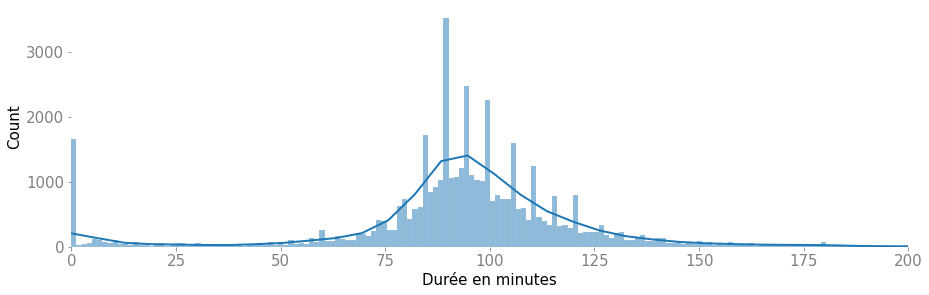

In [407]:
fig = plt.figure(figsize=(15,15))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)


f1=sns.histplot(data=df_pd ,x="runtime", kde=True,ax=fig.add_subplot(grid[0, :]))
f1.set_xlim(0,200)
f1.set_xlabel('Durée en minutes')

Text(0.5, 0, 'Moyenne des votes')

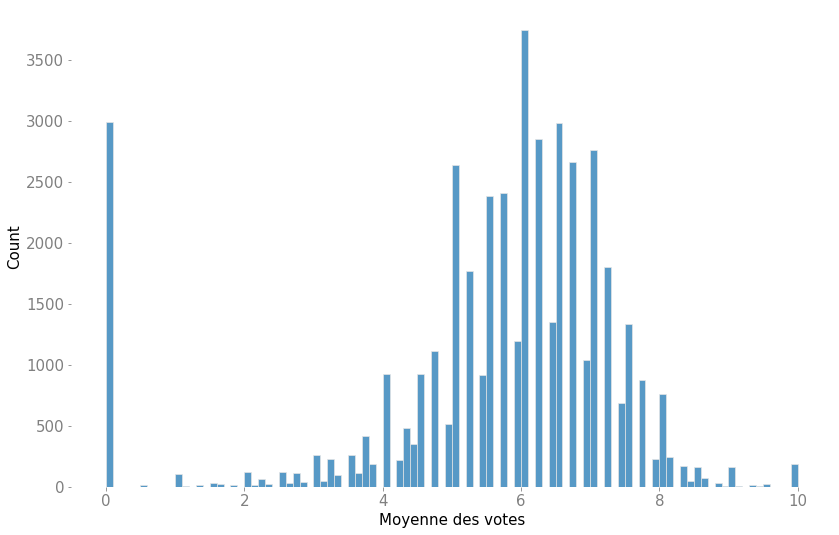

In [409]:
fig = plt.figure(figsize=(30,30))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)
f3=sns.histplot(data=df_pd ,x="vote_average", kde=False,ax=fig.add_subplot(grid[2,:1]))
f3.set_xlabel('Moyenne des votes')

(0.0, 3000.0)

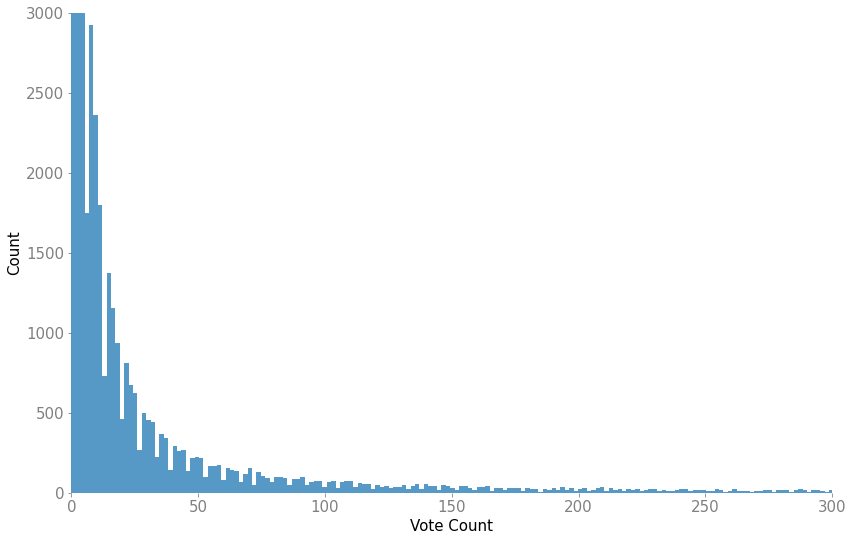

In [410]:
fig = plt.figure(figsize=(30,30))
f3=sns.histplot(data=df_pd ,x="vote_count", kde=False,ax=fig.add_subplot(grid[2,1]))
f3.set_xlabel('Vote Count')
f3.set_xlim(0,300)
f3.set_ylim(0,3000)

Matrice de correlation entre des variables quantitatives :         

* budget
* popularity
* revenue
* runtime
* vote_average
* vote_count

In [394]:
def plot_correlation(df, columns, figure_size=(10,6)):
    """
    This function takes a DataFrame as input and plots a heatmap of the correlations between the columns specified in the 'columns' parameter.
    It also accepts the following parameters for customization:
    - figure_size: a tuple specifying the width and height of the plot
    """
    # select the specified columns and add a column for profit/loss
    data_for_corr = df.select(*columns).withColumn("profit_loss", coalesce(col('revenue'), lit(0)) - coalesce(col('budget'), lit(0)))
    # convert to Pandas dataframe and drop rows with null values
    data_for_corr_pd = data_for_corr.toPandas().dropna(how='any')
    # calculate the correlations
    correlations = data_for_corr_pd.corr()
    # create the plot
    f,ax = plt.subplots(figsize=figure_size)
    sns.heatmap(correlations, annot=True, cmap="PiYG", linewidths=.10)
    plt.show()

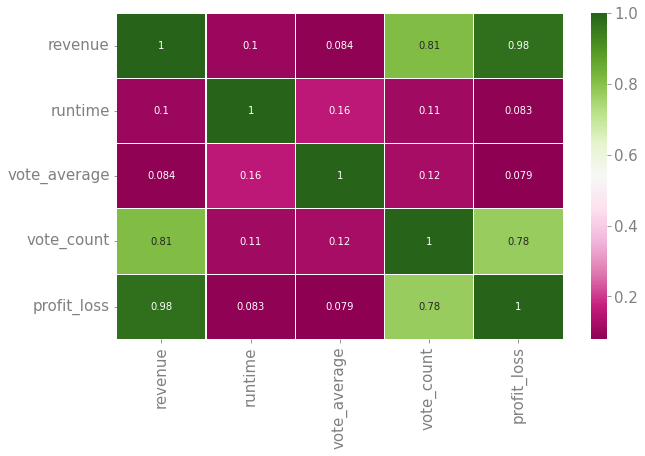

In [395]:
plot_correlation(df,('budget','popularity','revenue','runtime','vote_average','vote_count'))

Films ayant le plus de vote (top10)

In [396]:
def plot_top_movies_by_vote_count(df, num_movies):
    """
    This function takes a DataFrame of movies metadata as input and plots a bar chart of the top 'num_movies' movies by vote count.
    It also shows the vote count of each movie on top of the bar.
    """
    # convert to Pandas dataframe and sort by vote count
    df_pd_votecount = df.select('original_title','vote_count','vote_average').toPandas()
    df_pd_votecount = df_pd_votecount.sort_values(by='vote_count',ascending=False).iloc[0:num_movies,:].reset_index(drop=True)
    # create the plot
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    bar_plot = sns.barplot(x=df_pd_votecount['original_title'], y=df_pd_votecount['vote_count'], ax=ax)
    # rotate the x-axis labels for better visibility
    for tick in bar_plot.get_xticklabels():
        tick.set_rotation(90)
    # display the vote count on top of each bar
    for p in bar_plot.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height()+100
        value = format(int(p.get_height()))
        ax.text(_x, _y, value, ha="center") 
    plt.show()

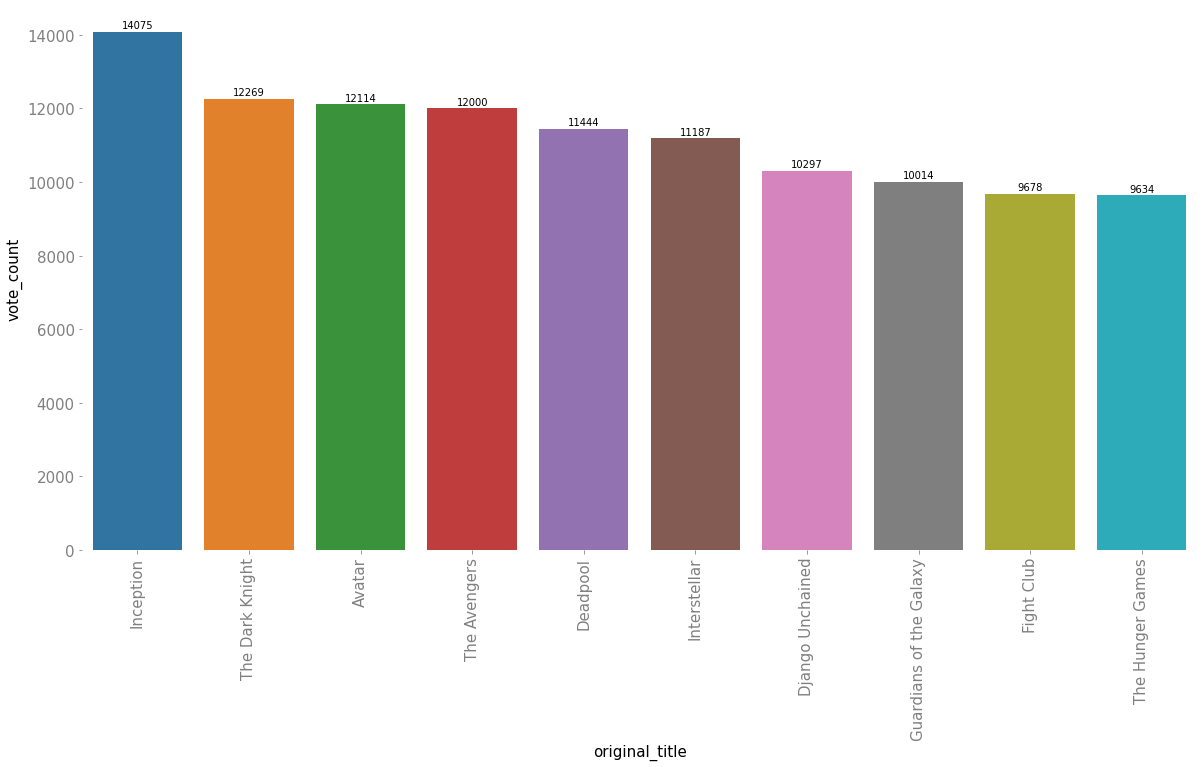

In [397]:
plot_top_movies_by_vote_count(df,10)

Films ayant générés les plus de revenue (top10)

In [425]:
def top_movies_by_revenue(df):
    """
    This function takes in a DataFrame and returns a bar plot of the top 10 movies by revenue.
    The x-axis represents the original title of the movie and the y-axis represents the revenue and budget of the movie.
    """
    # Select the columns 'id_ori', 'original_title', 'revenue', and 'budget' and order the DataFrame by revenue in descending order
    df_moviesByRevenue = df.select('id_ori','original_title','revenue','budget').orderBy(col('revenue'),ascending=False)

    # Convert the DataFrame to a Pandas DataFrame and select the top 10 movies by revenue
    df_pd_top10moviesByRevenue = df_moviesByRevenue.toPandas().head(10)

    # Create the bar plot
    ax = df_pd_top10moviesByRevenue.plot(x="original_title", y=["budget","revenue"], kind="bar", figsize=(15, 10),color= '#7eb54e')
    
    # Set the formatter for the y-axis to display values as currency
    formatter = FuncFormatter(currency)
    ax.yaxis.set_major_formatter(formatter)

    # Set the title, x-axis label, and y-axis label for the plot
    ax.set_title('Les 10 films avec le plus grand revenue', fontsize=20, loc='center')
    ax.set_xlabel('Titre du film', fontsize=19)
    ax.set_ylabel('Revenue (en dollard)', fontsize=19)
    
    # Add a legend to the plot
    plt.legend()
    plt.show()






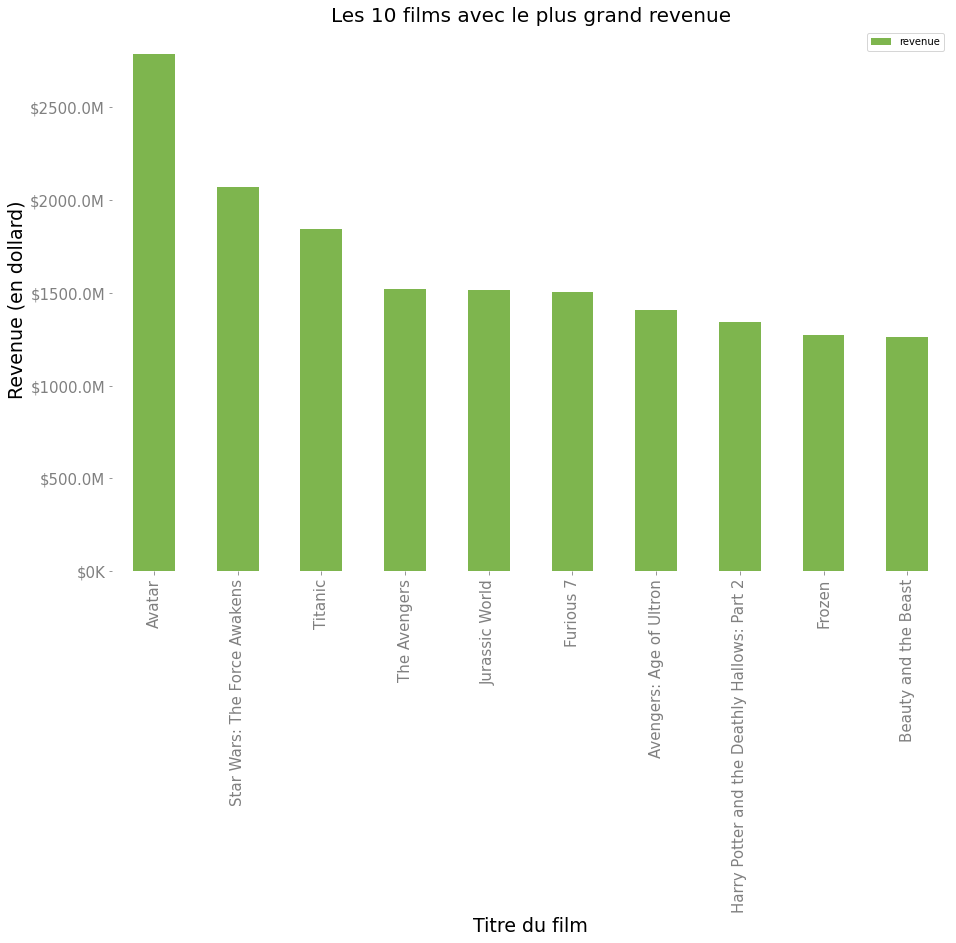

In [426]:
top_movies_by_revenue(df)

Nombre de films sortis par années (entre 1950 et 2017)

In [429]:
def movies_per_year(df):
    """
    This function takes in a DataFrame and returns a bar plot of the number of successful movies released per year in the 20th century.
    The x-axis represents the release year of the movie and the y-axis represents the number of movies released in that year.
    """
    # Filter out movies that don't have a release date and select the columns 'original_title', 'release_date', and 'release_year'
    # Group the DataFrame by release year and count the number of movies in each group
    # Convert the DataFrame to a Pandas DataFrame
    df_pd_moviesperYear = df.filter(col('release_date').isNotNull()).select('original_title','release_date',year(to_date(df.release_date,'yyyy-MM-dd')).alias('release_year'))\
                      .groupBy('release_year').count().toPandas()

    # Fill any missing values with 0 and change the data type of 'release_year' to int
    # Sort the DataFrame by release year in ascending order
    df_pd_moviesperYear = df_pd_moviesperYear.fillna(0).astype({'release_year':int}).sort_values(by='release_year',ascending=True,inplace=False,ignore_index=True)

    # Create the bar plot
    fig = px.bar(df_pd_moviesperYear, y='count', x='release_year', text='count',title='Nombre de film sorties par année entre 1950 et 2017')
    
    # Update the text template and position for the bars
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    
    # Update the layout of the plot
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    
    # Update the x-axis to display values between 1950 and 2018
    fig.update_xaxes(range=[1950,2018])
    
    # Show the plot
    fig.show()

In [430]:
movies_per_year(df)

Top 5 des franchises ayant produit le plus de films

In [402]:
def top_collections(df):
    """
    This function takes in a DataFrame and returns the top 5 collections by count.
    """
    # Filter out collections that are missing a name and select the 'name' column
    # Group the DataFrame by name and count the number of occurrences of each name
    # Order the DataFrame by count in descending order and convert it to a Pandas DataFrame
    df_pd_collection = df.where(col('name').isNotNull()).select(col('name')).groupBy(col('name')).count().orderBy(col('count').desc()).toPandas()

    # Print the top 5 collections by count
    print(df_pd_collection.head(5))

In [403]:
top_collections(df)

                            name  count
0                The Bowery Boys     29
1                Totò Collection     27
2          James Bond Collection     26
3  Zatôichi: The Blind Swordsman     26
4        The Carry On Collection     25


# 10 Visualisations en utilisant koalas

Utilision de koala pour de nouvelles visualisations 

In [404]:
import databricks.koalas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# convert to koalas ds
ratings_koa = ratings.to_koalas()
# plot ratings distribution
ratings_koa = ratings_koa.astype({'rating': float})
ratings_koa['rating'].hist() 


In [405]:
# convert to koalas ds
metadata_koa = movies_metadata.to_koalas()
# plot ratings distribution
metadata_koa = metadata_koa.astype({'budget': float})
metadata_koa['budget'].hist(bins=50) 


In [406]:
# plot runtime distribution
metadata_koa['runtime'] = metadata_koa['runtime'].astype('float32')
metadata_koa['runtime'].hist(bins=50)